# Analysis on Gigaword

Current structure:
* each metric has a DataFrame, df_metric
* df_metric has the score on all samples, from all models
* order of samples is consistent across different dfs, (i.e. different metrics)
* each df also has ordered labels

Correlations are of two types, as in this image:
* Sample Level
    * Take correlation b/w scores for models on EACH sample
    * Average over all samples

![sample](corr-sample.png)
![model](corr-model.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import sys
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [3]:
gigadir = '/home/ptejaswi/annotations/giga-org-test-shuf-1to300/'

df_r1 = pd.read_csv(os.path.join(gigadir, 'df_rouge1.csv'))
df_r2 = pd.read_csv(os.path.join(gigadir, 'df_rouge2.csv'))
df_rL = pd.read_csv(os.path.join(gigadir, 'df_rougeL.csv'))

df_m1 = pd.read_csv(os.path.join(gigadir, 'df_mvrs1.csv'))
# df_m2 = pd.read_csv(os.path.join(gigadir, 'df_mvrs2.csv'))
df_bs = pd.read_csv(os.path.join(gigadir, 'df_berts.csv'))

In [4]:
df_r1.mean()

pegasus            0.400394
coverage           0.354249
pgcov              0.344077
prophet            0.402465
control-copying    0.405902
biset              0.415504
unilm-v2           0.402455
dtype: float64

In [5]:
with open(os.path.join(gigadir, 'prophet', '_all.tgt.txt')) as fp:
    lengths = [len(l.strip().split()) for l in fp.readlines()]
    
assert len(lengths) == 200

In [6]:
df_m1.head()

,labels,pegasus,coverage,pgcov,prophet,control-copying,biset,unilm-v2
0,inference,0.234060,0.258795,0.370908,0.427303,0.650243,0.309341,0.243881
1,evidence,0.099651,-0.095140,-0.031290,0.003517,0.086252,0.048107,0.120532
2,paraphrase,0.548968,0.437701,0.223164,0.429920,0.379385,0.441376,0.535825
3,inference,0.448587,0.091713,0.090953,0.269805,0.321972,0.157035,0.528040
4,entity,0.100761,-0.038605,0.013545,0.083796,0.041736,0.108810,0.049461


In [7]:
from collections import Counter

In [8]:
Counter(df_m1.labels)

Counter({'inference': 18,
         'evidence': 16,
         'paraphrase': 44,
         'entity': 46,
         'extractive': 49,
         'incomplete': 27})

In [9]:
np.mean(df_m1.mean())

0.2568054298915358

In [10]:
by_label = df_m1.groupby('labels').mean()
by_label

,pegasus,coverage,pgcov,prophet,control-copying,biset,unilm-v2
labels,,,,,,,
entity,0.235184,0.184695,0.187851,0.214621,0.248513,0.247341,0.246839
evidence,0.130577,0.058039,0.076047,0.145388,0.127426,0.152641,0.135814
extractive,0.497629,0.371958,0.376553,0.495802,0.515932,0.486151,0.485516
incomplete,0.015524,0.003956,-0.008423,0.055842,0.033770,0.025227,0.021095
inference,0.205072,0.160158,0.149325,0.178231,0.202585,0.202347,0.202951
paraphrase,0.299321,0.247226,0.234911,0.317862,0.304267,0.316445,0.295705


In [11]:
avg_labels = by_label.mean(axis=1)
avg_labels

labels
entity        0.223578
evidence      0.117990
extractive    0.461363
incomplete    0.020999
inference     0.185810
paraphrase    0.287962
dtype: float64

In [12]:
series_all = pd.Series([np.mean(df_m1.mean())], index=['all'])
series_all

all    0.256805
dtype: float64

In [13]:
avg_labels.append(series_all)

entity        0.223578
evidence      0.117990
extractive    0.461363
incomplete    0.020999
inference     0.185810
paraphrase    0.287962
all           0.256805
dtype: float64

## Basic `bucket` analysis

In [14]:
mnames = ['rouge1', 'rouge2', 'rougeL', 'mvr1', 'berts']
mdfs = [df_r1, df_r2, df_rL, df_m1, df_bs]
mdatas = [x.values[:, 1:] for x in mdfs]

assert len(mnames) == len(mdfs)

In [15]:
overview = []

for name, df in zip(mnames, mdfs):
    score_models_full = df.mean()  # Mean across all samples, for each model => 1 x N_models
    score_avg = np.mean(score_models_full)  # Mean across all models  => 1 x 1
    
    gb_label = df.groupby('labels').mean()  # GB labels, mean across group samples, for each model => N_labels x N_models
    score_label = gb_label.mean(axis=1)  # In each group, mean across all models => N_labels x 1
    
    series_avg = pd.Series([score_avg], index=['all'])
    
    overview.append(score_label.append(series_avg))

In [16]:
score_avg

0.879474176977362

In [17]:
overview[-1]

entity        0.868694
evidence      0.859597
extractive    0.922574
incomplete    0.825011
inference     0.868422
paraphrase    0.887917
all           0.879474
dtype: float64

In [18]:
df_overview = pd.DataFrame(overview)
df_overview.index = mnames

In [19]:
df_overview

,entity,evidence,extractive,incomplete,inference,paraphrase,all
rouge1,0.328779,0.229609,0.627110,0.138512,0.310433,0.431929,0.389292
rouge2,0.151536,0.053092,0.404134,0.035614,0.110198,0.160472,0.188143
rougeL,0.309374,0.215865,0.600134,0.123611,0.263579,0.382006,0.359909
mvr1,0.223578,0.117990,0.461363,0.020999,0.185810,0.287962,0.256805
berts,0.868694,0.859597,0.922574,0.825011,0.868422,0.887917,0.879474


In [31]:
ordered_cols = ['position', 'incomplete', 'entity', 'evidence', 'extractive', 'paraphrase', 'inference', 'all']

In [38]:
groups_tikz = df_overview.round(2).copy()
groups_tikz['position'] = list(range(1, len(mnames)+1))
groups_tikz[ordered_cols].to_csv('./gigaword_group_data.txt', index=False, header=False, sep=' ')

In [40]:
groups_tikz[ordered_cols]

,position,incomplete,entity,evidence,extractive,paraphrase,inference,all
rouge1,1,0.14,0.33,0.23,0.63,0.43,0.31,0.39
rouge2,2,0.04,0.15,0.05,0.40,0.16,0.11,0.19
rougeL,3,0.12,0.31,0.22,0.60,0.38,0.26,0.36
mvr1,4,0.02,0.22,0.12,0.46,0.29,0.19,0.26
berts,5,0.83,0.87,0.86,0.92,0.89,0.87,0.88


In [39]:
!cat ./gigaword_group_data.txt

1 0.14 0.33 0.23 0.63 0.43 0.31 0.39
2 0.04 0.15 0.05 0.4 0.16 0.11 0.19
3 0.12 0.31 0.22 0.6 0.38 0.26 0.36
4 0.02 0.22 0.12 0.46 0.29 0.19 0.26
5 0.83 0.87 0.86 0.92 0.89 0.87 0.88


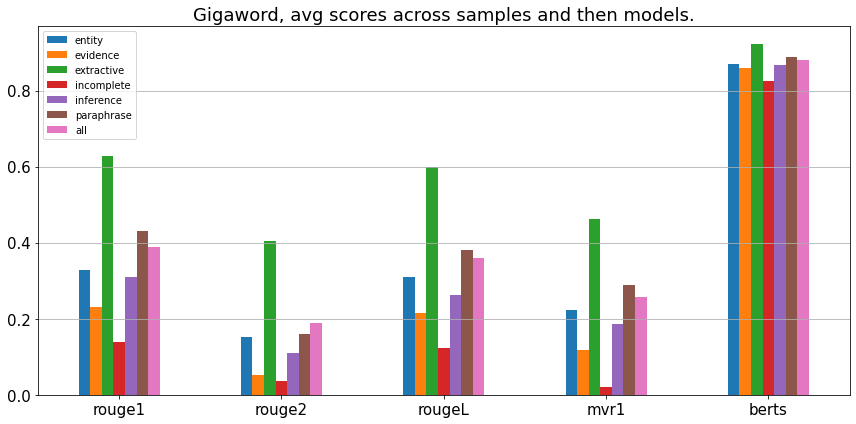

In [21]:
df_overview.plot.bar(rot=0, figsize=(12, 6), fontsize=15);
plt.title('Gigaword, avg scores across samples and then models.', fontsize=18)
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('overview_giga_buckets.png')

## System Rank correlations

In [41]:
import itertools
from collections import defaultdict

In [42]:
df_r1[df_r1.labels == 'incomplete'].head()

,labels,pegasus,coverage,pgcov,prophet,control-copying,biset,unilm-v2
15,incomplete,0.000000,0.133333,0.142857,0.000000,0.153846,0.153846,0.000000
28,incomplete,0.500000,0.666667,0.666667,0.500000,0.500000,0.500000,0.500000
40,incomplete,0.272727,0.260870,0.272727,0.173913,0.222222,0.347826,0.173913
43,incomplete,0.000000,0.250000,0.333333,0.285714,0.250000,0.250000,0.285714
71,incomplete,0.166667,0.153846,0.153846,0.166667,0.166667,0.166667,0.166667


In [43]:
df_m1[df_m1.labels == 'incomplete'].head()

,labels,pegasus,coverage,pgcov,prophet,control-copying,biset,unilm-v2
15,incomplete,0.021525,0.007545,0.051693,0.009257,0.026243,0.018265,-0.005015
28,incomplete,0.123534,0.140242,0.138809,0.122614,0.031312,0.122580,0.123305
40,incomplete,0.044387,0.086882,0.031021,0.012534,0.087157,0.019411,0.012121
43,incomplete,-0.075775,0.038888,0.158622,0.176876,0.163776,0.038797,0.179280
71,incomplete,0.133986,0.122874,0.124179,0.134004,0.122464,0.119199,0.133829


In [44]:
pearson_heatmap = np.eye(len(mnames))
spearman_heatmap = np.eye(len(mnames))

label_pear_heatmap = defaultdict(lambda : defaultdict(list))
label_sprm_heatmap = defaultdict(lambda : defaultdict(list))

ordered_labels = df_r1['labels'].tolist()

for m1, m2 in itertools.permutations(range(len(mnames)), 2):
    if m2 != m1:
        pearson_vals = []
        spearman_vals = []
        
        for i in range(200):
            row1 = mdatas[m1][i].tolist()
            row2 = mdatas[m2][i].tolist()
            rowlabel = ordered_labels[i]
            
            pr_score, pr_pval = pearsonr(row1, row2)
            if not np.isnan(pr_score):
                pearson_vals.append(pr_score)
                label_pear_heatmap[rowlabel][(m1, m2)].append(pr_score)
                
            sm_score, sm_pval = spearmanr(row1, row2)
            if not np.isnan(sm_score):
                spearman_vals.append(sm_score)
                label_sprm_heatmap[rowlabel][(m1, m2)].append(sm_score)
                
        pearson_heatmap[m1, m2] = np.nanmean(pearson_vals)
        spearman_heatmap[m1, m2] = np.nanmean(spearman_vals)

/projects/metis1/users/ptejaswi/anaconda3/envs/moverscore/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/projects/metis1/users/ptejaswi/anaconda3/envs/moverscore/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [45]:
pearson_heatmap

array([[1.        , 0.76222533, 0.89248723, 0.68035249, 0.5757088 ],
       [0.76222533, 1.        , 0.82615412, 0.68862593, 0.56565586],
       [0.89248723, 0.82615412, 1.        , 0.66969091, 0.56833565],
       [0.68035249, 0.68862593, 0.66969091, 1.        , 0.57325567],
       [0.5757088 , 0.56565586, 0.56833565, 0.57325567, 1.        ]])

In [46]:
with open('./gigaword_pearson.npy', 'wb') as fp:
    np.save(fp, pearson_heatmap)

In [50]:
spearman_heatmap

array([[1.        , 0.70030574, 0.87509664, 0.61256621, 0.54463974],
       [0.70030574, 1.        , 0.77650489, 0.59162733, 0.4978998 ],
       [0.87509664, 0.77650489, 1.        , 0.59901318, 0.5169396 ],
       [0.61256621, 0.59162733, 0.59901318, 1.        , 0.51268618],
       [0.54463974, 0.4978998 , 0.5169396 , 0.51268618, 1.        ]])

In [56]:
import matplotlib

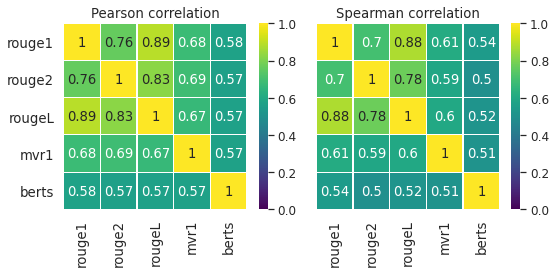

In [70]:
viridis = matplotlib.cm.get_cmap('viridis')

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
sns.set(font_scale=1.1)

sns.heatmap(pearson_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, 
            annot=True, ax=ax[0], cmap=viridis, vmin=0, vmax=1);
ax[0].set_title('Pearson correlation')

for tick in ax[0].get_yticklabels():
    tick.set_rotation(0)

sns.heatmap(spearman_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1,
            annot=True, ax=ax[1], cmap=viridis, vmin=0, vmax=1);
ax[1].set_title('Spearman correlation')

# sns.color_palette("viridis", as_cmap=True)

plt.tight_layout()
plt.savefig('giga_heatmaps_overview.png')

### System Rank, `bucket` level

In [51]:
label_pear_heatmap.keys()

dict_keys(['inference', 'evidence', 'paraphrase', 'entity', 'extractive', 'incomplete'])

/projects/metis1/users/ptejaswi/anaconda3/envs/moverscore/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


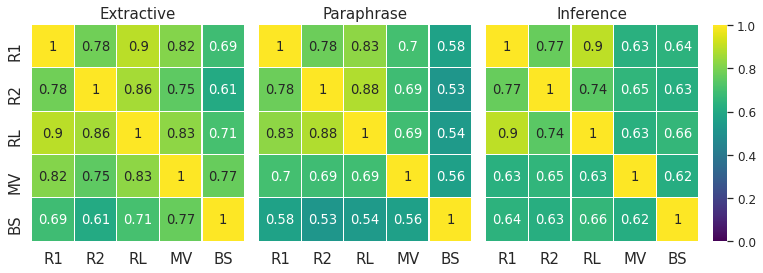

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
axes = axes.flatten()
i = 0

cbar_ax = fig.add_axes([1, 0.135, .02, 0.75])

# for label, hmdata in sorted(label_pear_heatmap.items()):
for label, hmdata in [('Extractive', label_pear_heatmap['extractive']),
                      ('Paraphrase', label_pear_heatmap['paraphrase']),
                      ('Inference', label_pear_heatmap['inference'])]:
    subhm = np.eye(len(mnames))
    ax = axes[i]
    for (m1, m2), vals in hmdata.items():
        subhm[m1, m2] = np.nanmean(vals)
    
    ticklabels = ['R1', 'R2', 'RL', 'MV', 'BS']
    
    sns.set(font_scale=1.1)
    
    b = sns.heatmap(subhm, xticklabels=ticklabels, yticklabels=ticklabels, linewidths=0.1, 
            annot=True, ax=ax, cmap='viridis', vmin=0, vmax=1, 
                    cbar=True if i == 2 else False, cbar_ax=cbar_ax if i == 2 else None);
    
    b.set_xticklabels(ticklabels, size = 15)
    b.set_yticklabels(ticklabels, size = 15)
    
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    ax.set_title(label, fontsize=15);
    i += 1
    
fig.tight_layout()
fig.savefig('giga_complexity_pearson.jpg', dpi=300, bbox_inches='tight')

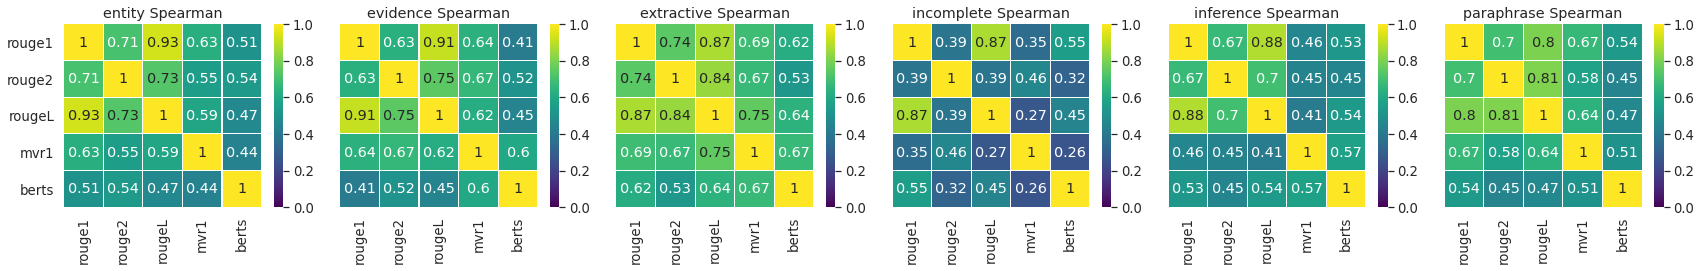

In [72]:
fig, axes = plt.subplots(1, 6, figsize=(24, 4), sharey=True)
axes = axes.flatten()
i = 0

sns.set(font_scale=1.2)
for label, hmdata in sorted(label_sprm_heatmap.items()):
    subhm = np.eye(len(mnames))
    ax = axes[i]
    for (m1, m2), vals in hmdata.items():
        subhm[m1, m2] = np.nanmean(vals)
        
    sns.heatmap(subhm, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, 
                annot=True, ax=ax, cmap='viridis', vmin=0, vmax=1);
    ax.set_title('%s Spearman' % label);
    i += 1
    
for tick in axes[0].get_yticklabels():
    tick.set_rotation(0)
    
fig.tight_layout()
fig.savefig('giga_labels_spearman.png')

## Sample Correlation

In [38]:
samples_pearson = np.eye(len(mnames))
samples_spearman = np.eye(len(mnames))

samples_label_pear = defaultdict(lambda : np.eye(len(mnames)))
samples_label_sprm = defaultdict(lambda : np.eye(len(mnames)))

ordered_labels = df_r1['labels'].tolist()

for m1, m2 in itertools.combinations(range(len(mnames)), 2):
    if m2 > m1:
        over_pr = np.nanmean(
            [pearsonr(mdfs[m1][model], mdfs[m2][model])[0] for model in df_r1.columns[1:]]
        )
        samples_pearson[m1, m2] = over_pr
        
        over_sm = np.nanmean(
            [spearmanr(mdfs[m1][model], mdfs[m2][model])[0] for model in df_r1.columns[1:]]
        )
        samples_spearman[m1, m2] = over_sm
        
        tempdf1 = mdfs[m1]
        tempdf2 = mdfs[m2]
        for label in set(ordered_labels):
            subset_pr = np.nanmean(
                [pearsonr(tempdf1[tempdf1['labels'] == label][model], 
                          tempdf2[tempdf2['labels'] == label][model])[0] for model in df_r1.columns[1:]]
            )
            samples_label_pear[label][m1, m2] = subset_pr
            
            subset_sm = np.nanmean(
                [spearmanr(tempdf1[tempdf1['labels'] == label][model], 
                           tempdf2[tempdf2['labels'] == label][model])[0] for model in df_r1.columns[1:]]
            )
            samples_label_sprm[label][m1, m2] = subset_sm

In [39]:
label, subset_pr, subset_sm

('inference', 0.8011306063229363, 0.7696531616945831)

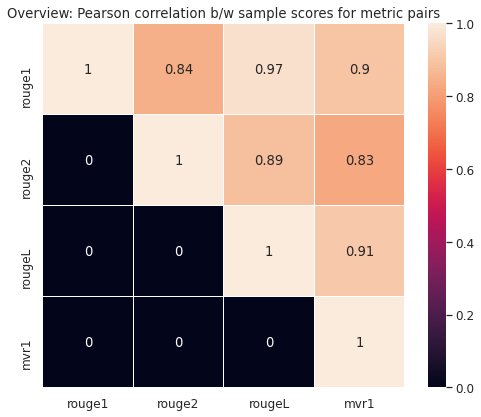

In [40]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.set(font_scale=1.1)
sns.heatmap(samples_pearson, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
ax.set_title('Overview: Pearson correlation b/w sample scores for metric pairs')
plt.tight_layout()
plt.savefig('hm_samples_pearson.png')

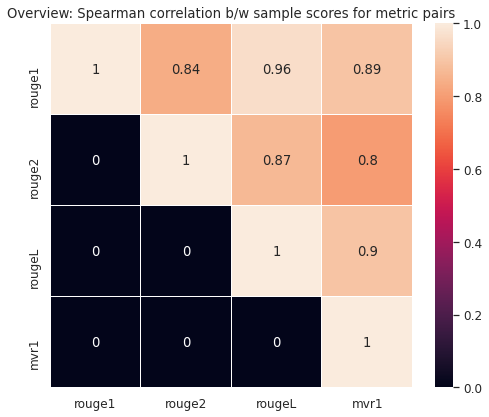

In [41]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.set(font_scale=1.1)
sns.heatmap(samples_spearman, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
ax.set_title('Overview: Spearman correlation b/w sample scores for metric pairs')
plt.tight_layout()
plt.savefig('hm_samples_spearman.png')

In [42]:
np.nanmean(
    [spearmanr(df_r1[df_r1.labels == 'extractive'][model], 
               df_m1[df_m1.labels == 'extractive'][model])[0] for model in df_r1.columns[1:]]
)

0.8524304081576979

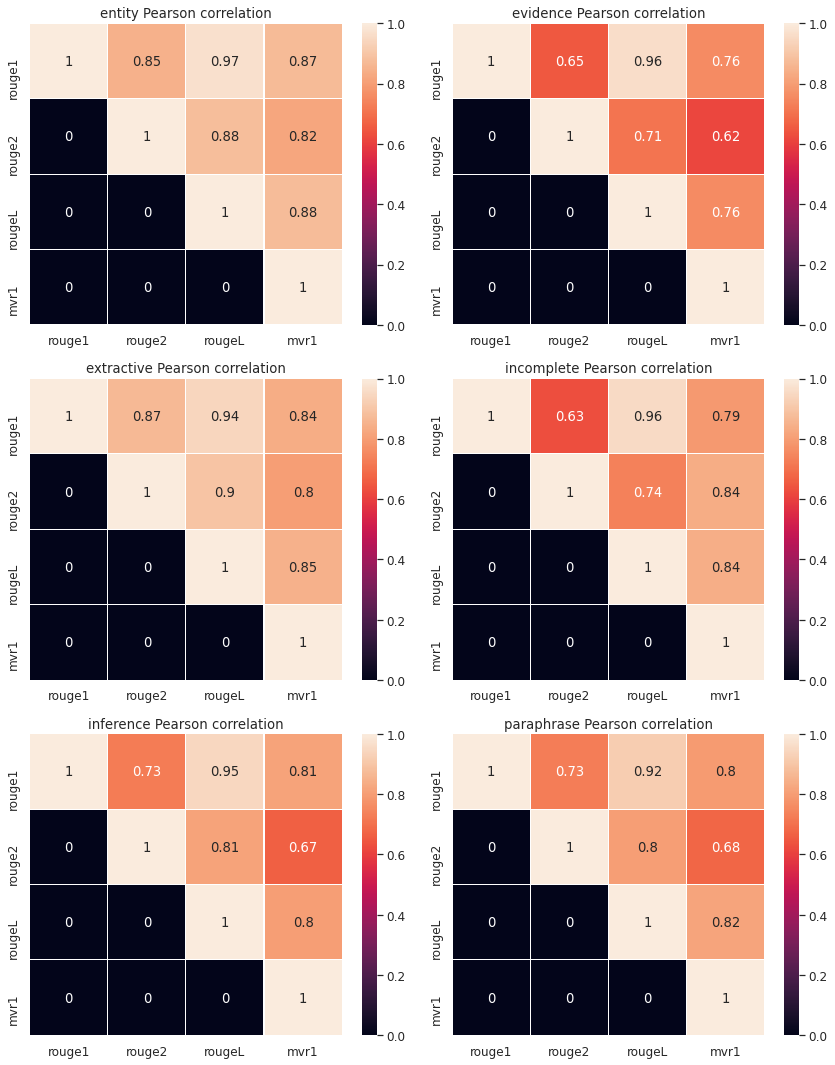

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()
i = 0
for label, hmdata in sorted(samples_label_pear.items()):
    ax = axes[i]
    sns.heatmap(hmdata, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
    ax.set_title('%s Pearson correlation' % label);
    i += 1
    
fig.tight_layout()
fig.savefig('hm_samples_labels_pearson.png')

In [44]:
label, hmdata

('paraphrase',
 array([[1.        , 0.72933312, 0.9210595 , 0.79549325],
        [0.        , 1.        , 0.80317932, 0.67720026],
        [0.        , 0.        , 1.        , 0.81729352],
        [0.        , 0.        , 0.        , 1.        ]]))

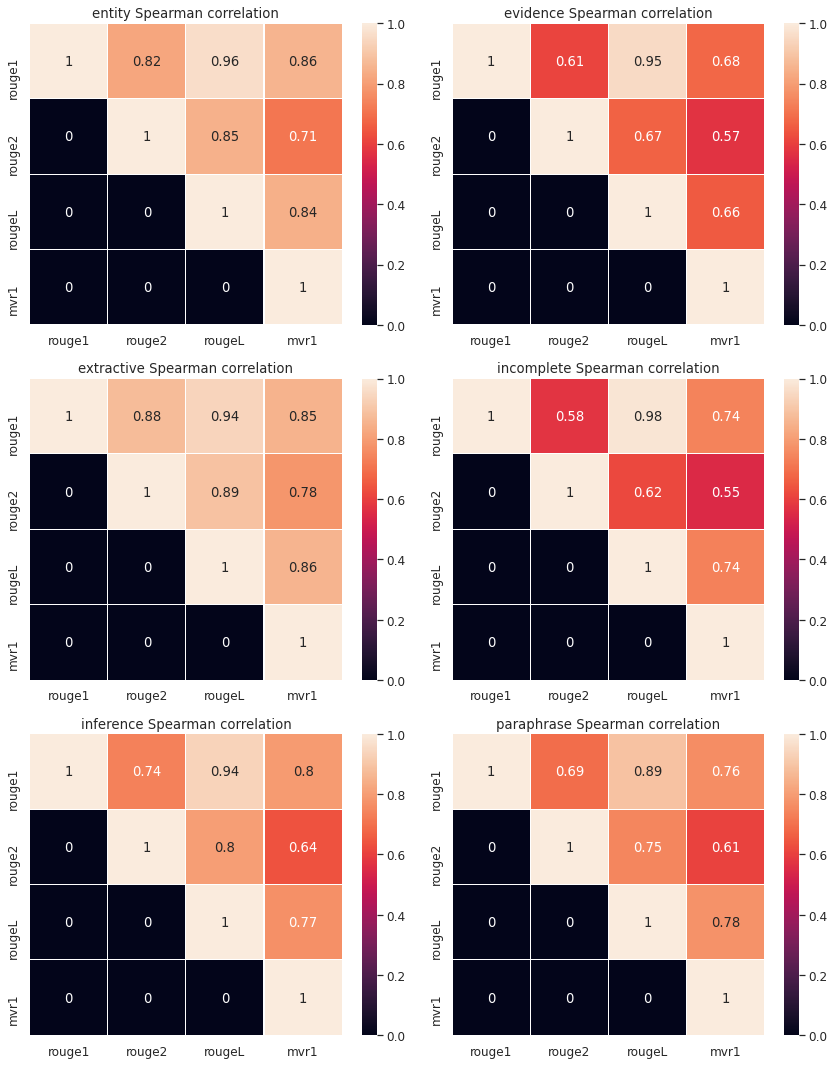

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()
i = 0
for label, hmdata in sorted(samples_label_sprm.items()):
    ax = axes[i]
    sns.heatmap(hmdata, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
    ax.set_title('%s Spearman correlation' % label);
    i += 1
    
fig.tight_layout()
fig.savefig('hm_samples_labels_spearman.png')

In [38]:
np.round(samples_label_sprm['extractive'], 2)

array([[1.  , 0.89, 0.93, 0.84, 0.83],
       [0.  , 1.  , 0.9 , 0.8 , 0.78],
       [0.  , 0.  , 1.  , 0.84, 0.84],
       [0.  , 0.  , 0.  , 1.  , 0.99],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])

## Manual analysis